# Sentiment Analysis with CNN and LSTM

In [ ]:
import pandas as pd
import random
from underthesea import word_tokenize
from sklearn.utils import resample
from collections import Counter

# Load dữ liệu gốc
df = pd.read_csv("momo_reviews_labeled.csv")

# Lấy văn bản và nhãn
X = df["Noi_dung_sach_giu_dau"]
y = df["label"]
df_bal = df.copy()

# Đếm số lượng mỗi lớp
class_counts = df["label"].value_counts()
max_count = class_counts.max()

# Hàm thay từ đồng nghĩa đơn giản (giả lập)
def simple_synonym_replace(text):
    replacements = {
        "hay": ["tuyệt", "xuất sắc"],
        "buồn": ["ảm đạm", "sầu"],
        "tệ": ["kém", "dở"],
        "vui": ["hài", "thú vị"],
        "diễn viên": ["diễn xuất", "diễn giả"],
        "kịch bản": ["nội dung", "cốt truyện"],
    }
    words = word_tokenize(text, format="text").split()
    new_words = []
    for word in words:
        lw = word.lower()
        if lw in replacements and random.random() < 0.5:
            new_words.append(random.choice(replacements[lw]))
        else:
            new_words.append(word)
    return " ".join(new_words)

# Augment dữ liệu để cân bằng
augmented_rows = []
for label in class_counts.index:
    df_class = df[df["label"] == label]
    n_samples_needed = max_count - len(df_class)
    if n_samples_needed > 0:
        augmented_texts = resample(df_class, replace=True, n_samples=n_samples_needed, random_state=42)
        augmented_texts = augmented_texts.copy()
        augmented_texts["Noi_dung_sach_giu_dau"] = augmented_texts["Noi_dung_sach_giu_dau"].apply(simple_synonym_replace)
        augmented_rows.append(augmented_texts)

# Gộp lại vào DataFrame cân bằng
df_aug = pd.concat([df] + augmented_rows, ignore_index=True)

# Kiểm tra lại phân phối nhãn
print("Phân phối nhãn sau khi cân bằng:")
print(df_aug["label"].value_counts())

# Lưu file để dùng cho CNN+LSTM
df_aug.to_excel("momo_reviews_balanced_augmented_CNNLSTM.xlsx", index=False)
print("\nĐã lưu file: momo_reviews_balanced_augmented_CNNLSTM.xlsx")


## Import lib 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils


In [2]:
# Kiểm tra pyvi

from pyvi import ViTokenizer

ViTokenizer.tokenize("Tôi yêu đất nước Việt Nam")  


'Tôi yêu đất_nước Việt_Nam'

## Load Data 

In [3]:
data = pd.read_excel('momo_reviews_balanced_augmented_CNNLSTM.xlsx')

In [4]:
data.sample(5)

,Tên phim,Người đánh giá,Điểm,Nhãn cảm xúc,Nội dung đánh giá,Noi_dung_sach,Noi_dung_sach_giu_dau,label
11153,Review phim Kẻ Ăn Hồn trên MoMo,Nguyễn Văn Trí,6/10,Tạm ổn,Gọi là phim đáng mong chờ thì tôi ko nghĩ vậy....,goi la phim dang mong cho thi toi không nghi v...,gọi là phim đáng mong_chờ thì tôi không nghĩa ...,Trung lập
9247,Review phim Cô Dâu Hào Môn trên MoMo,Hà Hữu Hân Hạnh,4/10,Chưa ưng lắm,Mua 4 vé 20/10 suất 13h40 rạp bị huỷ ko được c...,mua ve 20 10 suat 13h40 rap bi huy không duoc ...,mua vé 20 10 suất 13 h40_rạp bị hủy không được...,Tiêu cực
8861,Review phim Kappa: Ác Linh Dưới Đáy Hồ trên MoMo,Phạm Xuân Quang,1/10,Kén người mê,Lần đầu tiên xem xong một phim mà tức quá phải...,lan dau tien xem xong mot phim ma tuc qua phai...,lần đầu_tiên xem xong một phim mà tức quá phải...,Tiêu cực
4069,Review phim Tìm Xác: Ma Không Đầu trên MoMo,Trần Quốc Đạt,10/10,Cực phẩm!,"Em cần để lại 3 vé suất 6g tại gala tân bình ,...",em can de lai ve suat 6g tai gala tan binh cin...,em cần để lại vé suất 6g tại gala tân bình cin...,Tích cực
6729,Review phim Aquaman: Vương Quốc Thất Lạc trên ...,Vu Van Thanh,3/10,Chưa ưng lắm,Đạo diện thiếu muối quá phim copy ý tưởng cũ m...,dao dien thieu muoi qua phim copy tuong cu mem...,đạo_diện thiếu muối quá phim copy_tưởng cũ_mèm...,Tiêu cực


## Create Input + Label From Raw Data 

In [5]:
sentiment_data = pd.DataFrame({'input': data['Noi_dung_sach_giu_dau'],'label':data['label']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)
sentiment_data.head()

,input,label
0,phim thì quá xuất sắc đối với cá nhân mình ghế...,Tích cực
1,mình nghĩa mọi ng nên đi xem phim này lúc đầu ...,Tích cực
2,phim hay nếu hiểu biết về bối cảnh lịch sử giữ...,Tích cực
3,phải nói là đỉnh luôn á phim có nói về lịch sử...,Tích cực
4,các cảnh phim chủ yếu màu tối mỗi hình ảnh phi...,Tích cực


### Label Negative

In [ ]:
# Tìm các câu trong dataset chứa từ "thất vọng" để kiểm tra nhãn
sentiment_data[sentiment_data['input'].str.contains("thất vọng", case=False)]


In [ ]:
df_conflict = sentiment_data[sentiment_data['input'].str.contains("thất vọng", case=False)]

In [ ]:
def reassign_label(text):
    if "thất vọng" in text.lower():
        return "Tiêu cực"
    return None  # Không thay đổi

sentiment_data['relabel'] = sentiment_data['input'].apply(reassign_label)

In [ ]:
sentiment_data['label'] = sentiment_data['relabel'].combine_first(sentiment_data['label'])
sentiment_data.drop(columns='relabel', inplace=True)

In [ ]:
print(sentiment_data['label'].value_counts())

## Preprocessing data & Prepare Data For Training 

In [ ]:
# # Loss weighting
# from torch.nn import CrossEntropyLoss
# import torch

# # Ví dụ label: ['Tiêu cực', 'Trung lập', 'Tích cực']
# weights = torch.tensor([1/334, 1/317, 1/4801])  # theo tỉ lệ ngược
# weights = weights / weights.sum()
# loss_fn = CrossEntropyLoss(weight=weights.to(device))


In [ ]:
# # RandomOverSampler
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X_raw.to_frame(), y)

In [7]:
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

label_dict = {'tiêu cực': 0, 'trung lập': 1, 'tích cực': 2}

input_pre = []
label_with_accent = []

for idx, dt in enumerate(input_data):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
    
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)

    label = input_label[idx].strip().lower()  # chuẩn hóa nhãn trước khi dùng
    label_with_accent.append(label)
    label_with_accent.append(label)


In [ ]:
# seq_len = [len(i.split()) for i in input_pre[0:5000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[10000:15000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[15000:20000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[20000:25000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[25000:30000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

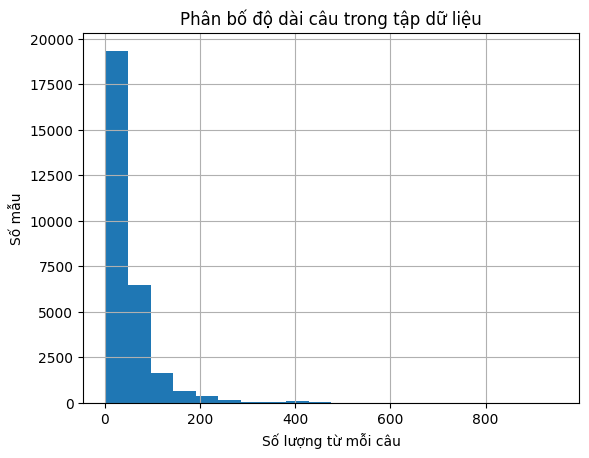

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

seq_len = [len(i.split()) for i in input_pre]
pd.Series(seq_len).hist(bins=20)
plt.xlabel("Số lượng từ mỗi câu")
plt.ylabel("Số mẫu")
plt.title("Phân bố độ dài câu trong tập dữ liệu")
plt.grid(True)
plt.show()


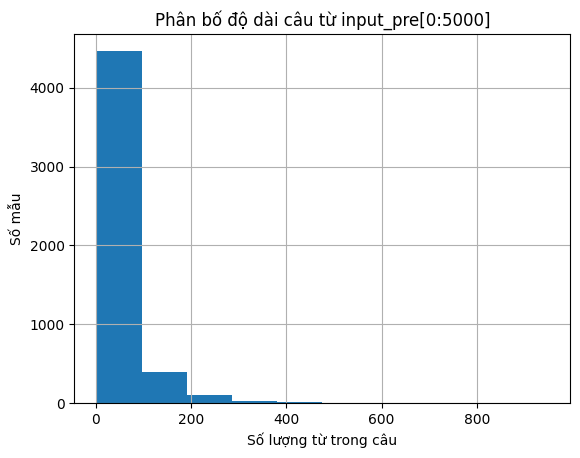

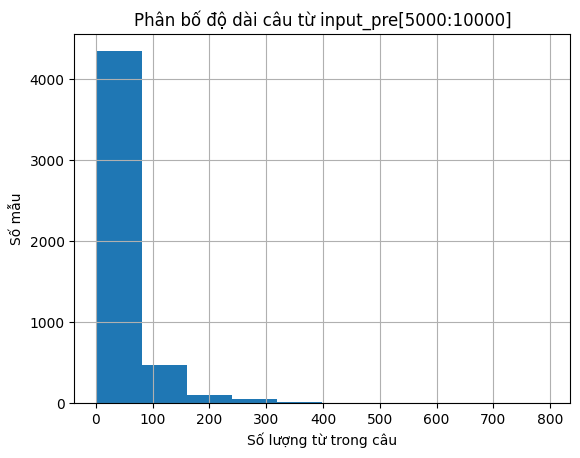

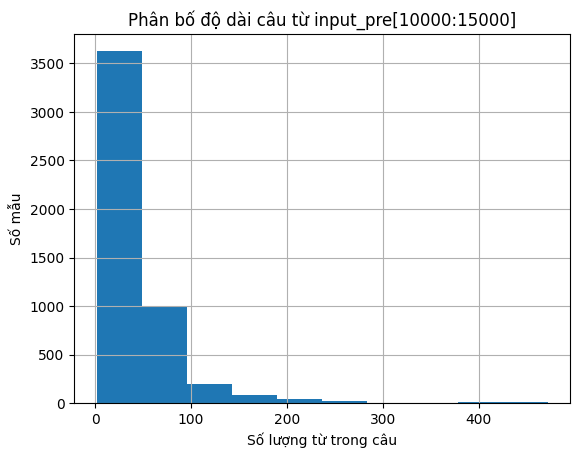

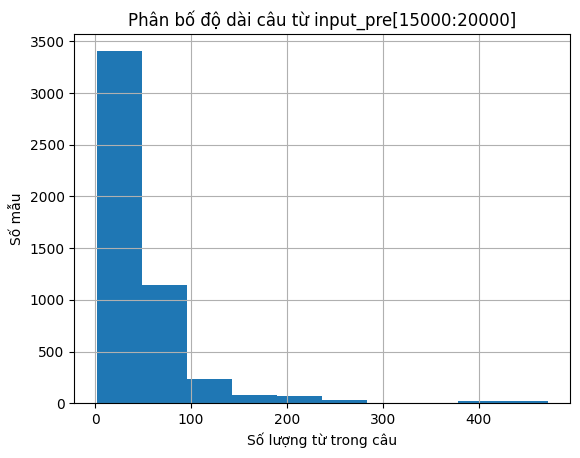

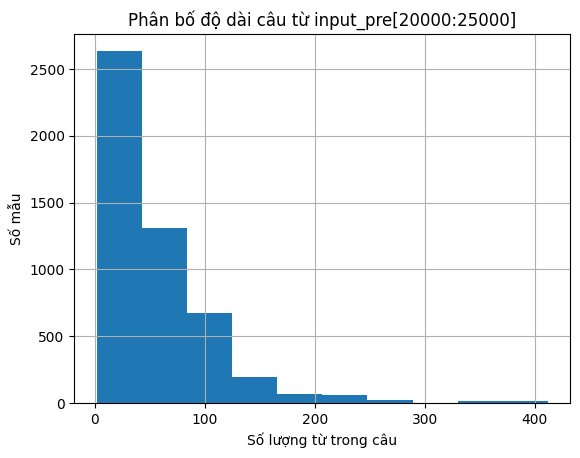

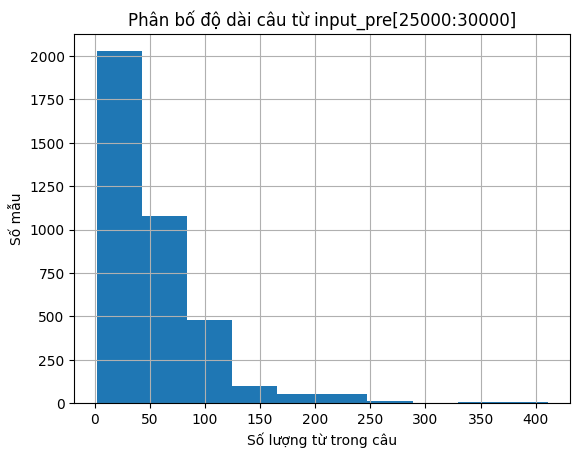

In [9]:
# Cắt và vẽ biểu đồ theo từng đoạn để xem phân bố độ dài câu
for i in range(0, len(input_pre), 5000):
    seq_len = [len(x.split()) for x in input_pre[i:i+5000]]
    pd.Series(seq_len).hist(bins=10)
    plt.title(f"Phân bố độ dài câu từ input_pre[{i}:{i+5000}]")
    plt.xlabel("Số lượng từ trong câu")
    plt.ylabel("Số mẫu")
    plt.show()


In [10]:
import numpy as np

seq_lengths = [len(i.split()) for i in input_pre]
print("Độ dài trung bình:", np.mean(seq_lengths))
print("Độ dài lớn nhất:", max(seq_lengths))
print("Độ dài 95% phân vị:", np.percentile(seq_lengths, 95))


Độ dài trung bình: 46.23686037631049
Độ dài lớn nhất: 949
Độ dài 95% phân vị: 140.0


In [ ]:
# import numpy as np

# # label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')
# label_idx = [label_dict[i] for i in label_with_accent]
# label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3).astype(np.float32)


# tokenizer_data = Tokenizer(oov_token='<OOV>', filter = '', split=' ')
# tokenizer_data.fit_on_texts(input_pre)

# tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
# vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=250)

# pickle.dump(tokenized_data, open("token_data.pkl", "wb"))

# print("input data.shape", vec_data.shape)
# data_vocab_size = len(tokenizer_data.word_index) + 1
# print("data_vocab_size: ", data_vocab_size)

# X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size = 0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)
# print("training sample: ", len(X_train))
# print("validation sample: ", len(X_val))
# print("test sample: ", len(X_test))

In [11]:
# Chuyển nhãn sang one-hot vector và ép kiểu float32
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3).astype(np.float32)

# Khởi tạo tokenizer - không dùng 'filter' vì không còn được hỗ trợ
tokenizer_data = Tokenizer(oov_token='<OOV>', split=' ')
tokenizer_data.fit_on_texts(input_pre)

# Chuyển văn bản thành chuỗi số và pad độ dài
tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=140)

# Lưu tokenizer
pickle.dump(tokenizer_data, open("token_data.pkl", "wb"))

# In thông tin
print("input data.shape", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index) + 1
print("data_vocab_size: ", data_vocab_size)

# Chia dữ liệu train/val/test
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("training sample: ", len(X_train))
print("validation sample: ", len(X_val))
print("test sample: ", len(X_test))

input data.shape (28806, 140)
data_vocab_size:  7941
training sample:  20739
validation sample:  5762
test sample:  2305


## Create Model From Scratch 

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D, Dropout, Dense,
    LSTM, GRU, Bidirectional, GlobalMaxPooling1D,
    LayerNormalization, Concatenate
)
from tensorflow.keras.optimizers import Adam


In [13]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 140
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape= (input_length,))
    feature = Embedding(input_dim=input_dim, output_dim= output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    bi_lstm_feature = Bidirectional(GRU(units=32, dropout = dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # classifier = Dense(90, activation='relu')(combine_feature)
    # classifier = Dropout(0.2)(classifier)
    # classifier = Dense(70, activation='relu')(classifier)
    # classifier = Dropout(0.2)(classifier)
    # classifier = Dense(50, activation='relu')(classifier)
    # classifier = Dropout(0.2)(classifier)
    # classifier = Dense(30, activation="relu")(classifier)
    # classifier = Dropout(0.2)(classifier)
    # classifier = Dense(3, activation='softmax')(classifier)

    classifier = Dense(64, activation='relu')(combine_feature)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(32, activation='relu')(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)


    model = tf.keras.Model(inputs = input_layer, outputs = classifier)

    return model
model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 140, 32)      254112      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 140, 32)      3104        ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 70, 32)       0           ['conv1d[0][0]']                 
                                                                                              

## Visualize Model Architecture 

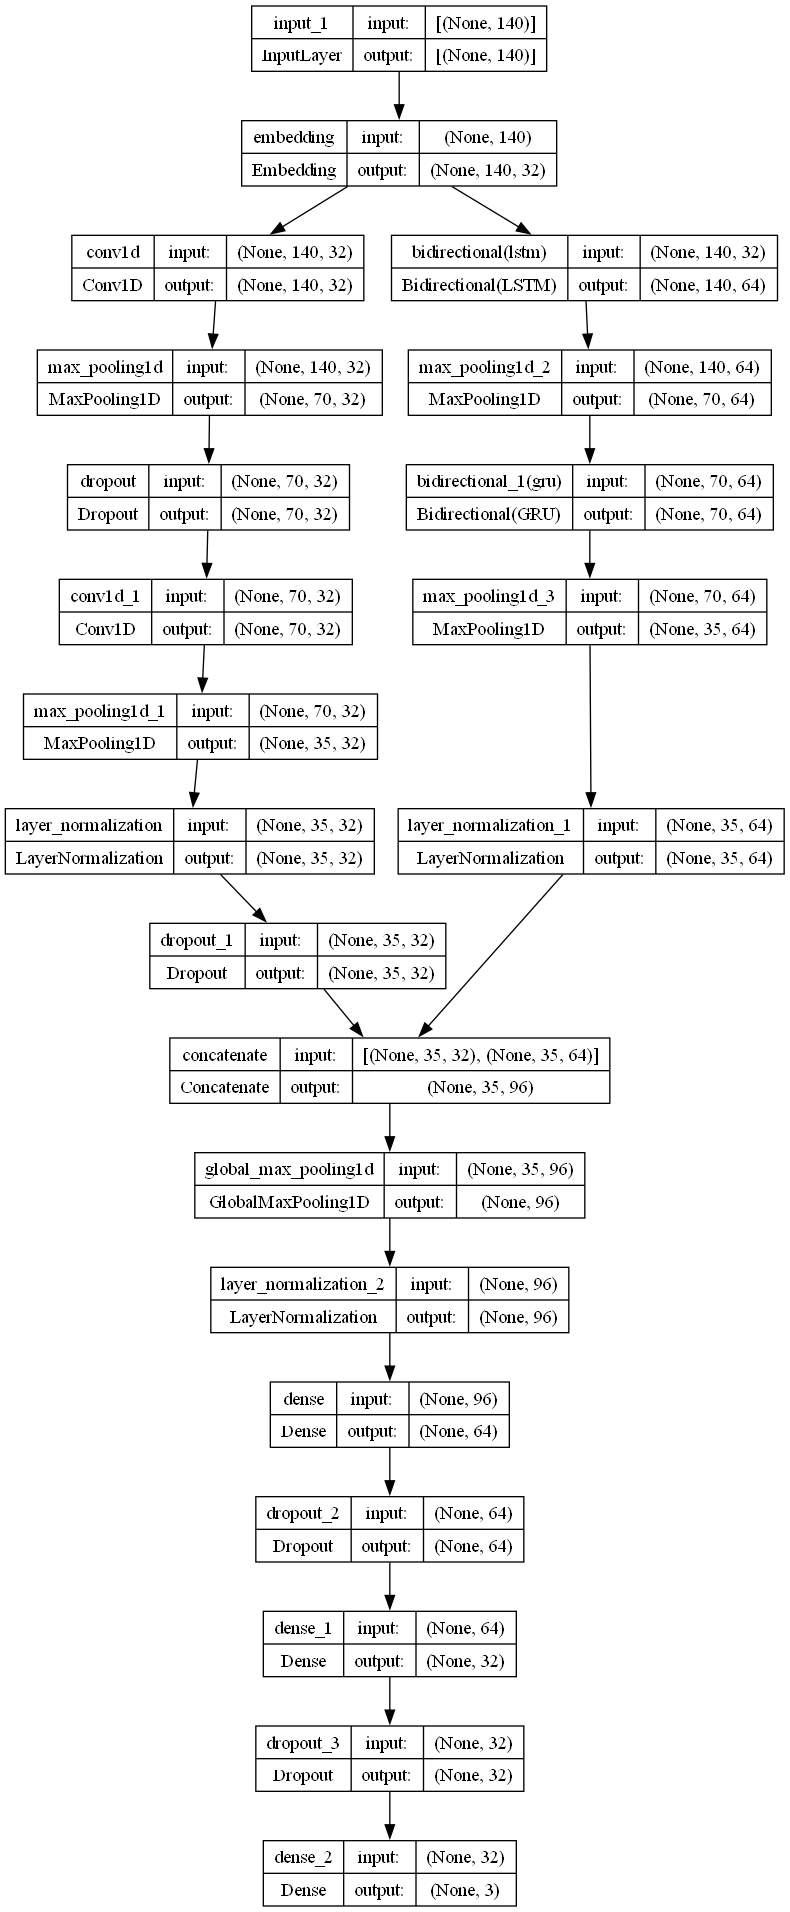

In [14]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
# callback_model = tf.keras.callbacks.ModelCheckpoint(
#     'model_cnn_bilstm.h5', monitor='val_loss', save_best_only=True
# )

# history = model.fit(
#     x=X_train,
#     y=y_train,
#     validation_data=(X_val, y_val),
#     epochs=15,
#     batch_size=32,
#     callbacks=[callback_model]
# )


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Lưu mô hình tốt nhất
callback_model = ModelCheckpoint(
    'model_cnn_bilstm_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Dừng sớm nếu val_loss không giảm sau 3 epoch
callback_earlystop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Giảm learning rate nếu val_loss không cải thiện
callback_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# Huấn luyện mô hình với các callback
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[callback_model, callback_earlystop, callback_reduce_lr]
)


Epoch 1/15
649/649 [==============================] - ETA: 0s - loss: 1.0194 - accuracy: 0.4440
Epoch 1: val_loss improved from inf to 0.74628, saving model to model_cnn_bilstm_best.h5
649/649 [==============================] - 85s 120ms/step - loss: 1.0194 - accuracy: 0.4440 - val_loss: 0.7463 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 2/15
649/649 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.7969
Epoch 2: val_loss improved from 0.74628 to 0.22840, saving model to model_cnn_bilstm_best.h5
649/649 [==============================] - 76s 117ms/step - loss: 0.5294 - accuracy: 0.7969 - val_loss: 0.2284 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 3/15
649/649 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9244
Epoch 3: val_loss improved from 0.22840 to 0.15613, saving model to model_cnn_bilstm_best.h5
649/649 [==============================] - 83s 128ms/step - loss: 0.2326 - accuracy: 0.9244 - val_loss: 0.1561 - val_accuracy: 0.9471 - lr: 0.0

## Model Evaluation On Test Data 

In [16]:
model.load_weights("model_cnn_bilstm_best.h5")
model.evaluate(X_test, y_test)

73/73 [==============================] - 2s 24ms/step - loss: 0.0686 - accuracy: 0.9848


[0.06856042146682739, 0.9848155975341797]

## Inference Model With Input Test 

In [17]:
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = tf.keras.preprocessing.text.text_to_word_sequence(raw_input)
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print("Text preprocessed:", input_text_pre_accent)

    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=140)
    return vec_data

def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {0: 'Tiêu cực', 1: 'Trung lập', 2: 'Tích cực'}
    return label_dict[result], conf

def prediction_model(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)
    result, conf = inference_model(input_model, model)
    return result, conf

# Load model và tokenizer
from tensorflow.keras.models import load_model

my_model = load_model('model_cnn_bilstm_best.h5')

with open("token_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

# Test
print(prediction_model("Diễn viên tốt nhưng kịch bản hơi chán.", my_tokenizer, my_model))


Text preprocessed: diễn_viên tốt nhưng kịch_bản hơi chán
('Tích cực', 0.9923031330108643)


In [21]:
while True:
    text = input("Nhập nội dung (gõ 'end' để thoát): ")
    if text.lower().strip() == "end":
        break
    else:
        result, conf = prediction_model(text, my_tokenizer, my_model)
        print(f"Kết quả: {result} (độ tin cậy: {conf:.2f})\n")


Text preprocessed: diễn_viên tốt nhưng kịch_bản hơi chán
Kết quả: Tích cực (độ tin cậy: 0.99)



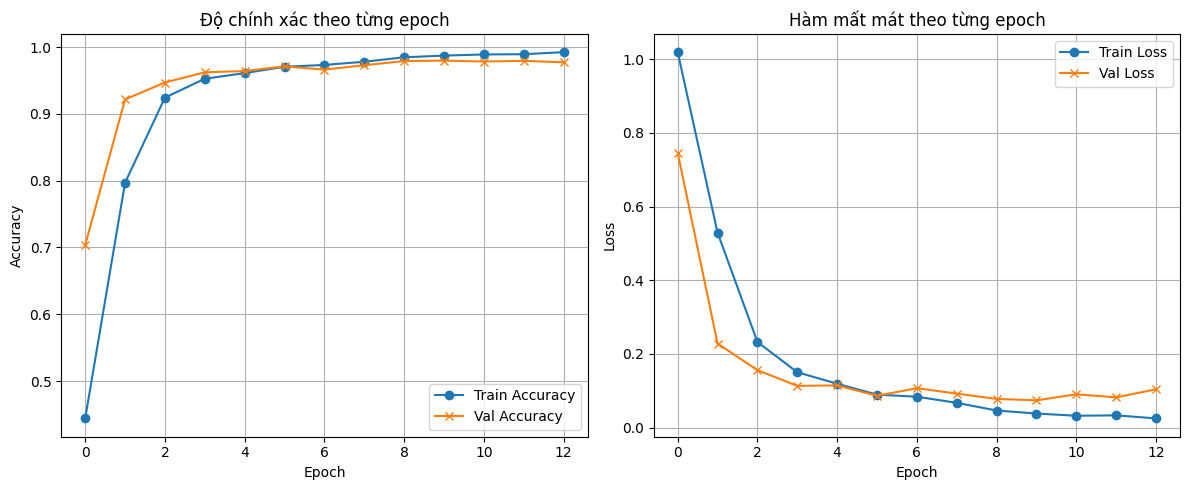

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
    plt.title('Độ chính xác theo từng epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
    plt.title('Hàm mất mát theo từng epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ sau khi train
plot_training_history(history)


In [24]:
def prediction_model(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)

    # Lấy xác suất dự đoán từ mô hình
    probs = model.predict(input_model, verbose=0)[0]  # Lấy 1 dòng đầu vì chỉ có 1 mẫu
    result_idx = probs.argmax()
    confidence = float(probs[result_idx])
    label_dict = {0: 'Tiêu cực', 1: 'Trung lập', 2: 'Tích cực'}

    return label_dict[result_idx], confidence, probs


In [27]:
while True:
    text = input("Nhập nội dung (gõ 'end' để thoát): ")
    if text.lower().strip() == "end":
        break
    else:
        result, conf, probs = prediction_model(text, my_tokenizer, my_model)
        
        print("\n--- PHÂN TÍCH CẢM XÚC ---")
        print(f"Nội dung: {text}")
        print(f"Dự đoán cảm xúc: {result} (Độ tin cậy: {conf:.2f})")
        print("Phân bố xác suất:")
        print(f"  - Tiêu cực: {probs[0] * 100:.2f}%")
        print(f"  - Trung lập: {probs[1] * 100:.2f}%")
        print(f"  - Tích cực: {probs[2] * 100:.2f}%\n")


Text preprocessed: phim hay nên đi xem nha mọi người

--- PHÂN TÍCH CẢM XÚC ---
Nội dung: phim hay nên đi xem nha mọi người
Dự đoán cảm xúc: Tích cực (Độ tin cậy: 1.00)
Phân bố xác suất:
  - Tiêu cực: 0.00%
  - Trung lập: 0.00%
  - Tích cực: 100.00%

Text preprocessed: phim dở quá đi coi phí tiền xem mà muốn đi ngủ không á

--- PHÂN TÍCH CẢM XÚC ---
Nội dung: phim dở quá, đi coi phí tiền, xem mà muốn đi ngủ không á
Dự đoán cảm xúc: Tiêu cực (Độ tin cậy: 1.00)
Phân bố xác suất:
  - Tiêu cực: 100.00%
  - Trung lập: 0.00%
  - Tích cực: 0.00%

Text preprocessed: phim này rất bình_thường chẳng có gì để xem

--- PHÂN TÍCH CẢM XÚC ---
Nội dung: phim này rất bình thường, chẳng có gì để xem
Dự đoán cảm xúc: Trung lập (Độ tin cậy: 0.96)
Phân bố xác suất:
  - Tiêu cực: 0.09%
  - Trung lập: 95.63%
  - Tích cực: 4.29%

Text preprocessed: diễn_viên tốt nhưng kịch_bản hơi chán

--- PHÂN TÍCH CẢM XÚC ---
Nội dung: Diễn viên tốt nhưng kịch bản hơi chán
Dự đoán cảm xúc: Tích cực (Độ tin cậy: 0.99)
Phân 